In [1]:
import re
import nltk
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


### Read the raw analyst rating file ###

In [2]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(r'C:\Users\Hp\Desktop\10_Academy\week-1\Data\raw_analyst_ratings.csv\raw_analyst_ratings.csv')

# Display the first few rows of the data
print(df.head())


   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

### Descriptive statistics 

Descriptive Statistics for Headline Lengths:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


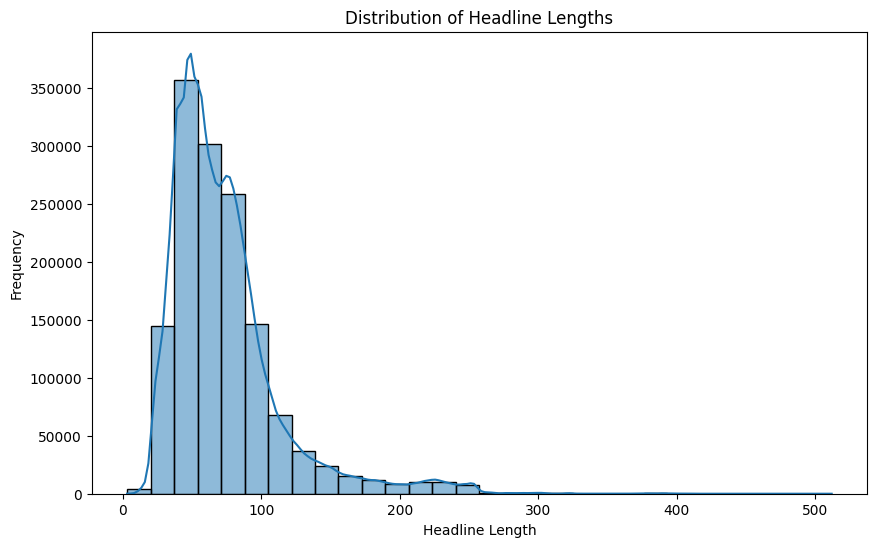


Number of Articles per Publisher:
publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


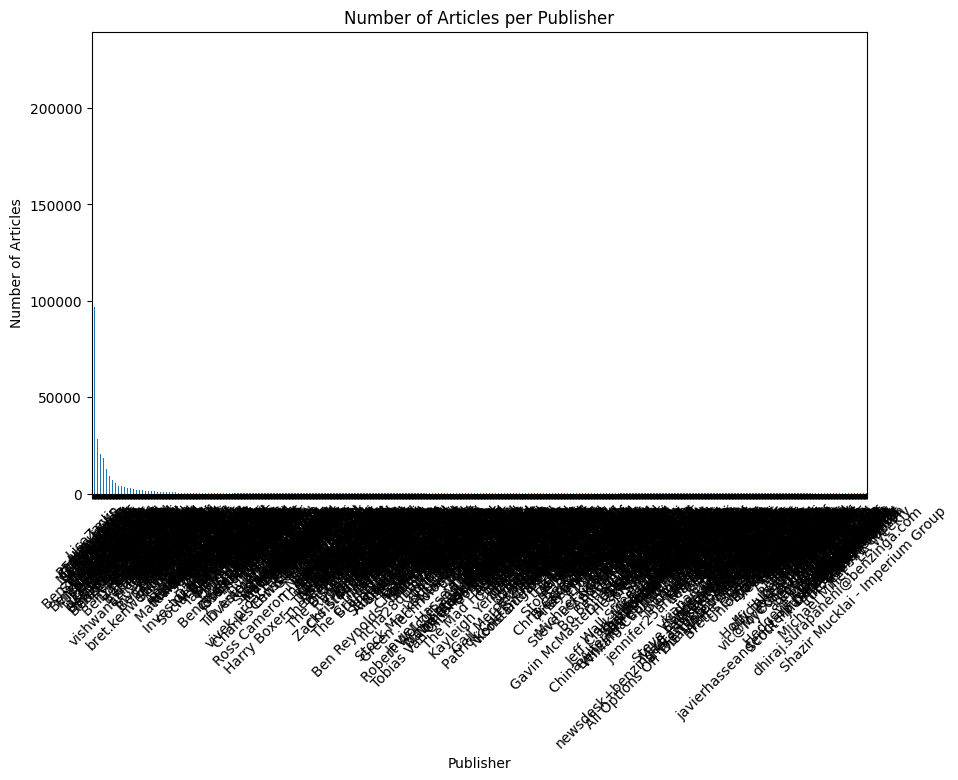


Number of Articles Published Over Time:
publication_date
2009-02-14      1
2009-04-27      2
2009-04-29      1
2009-05-22      1
2009-05-27      6
             ... 
2020-05-30     14
2020-05-31     17
2020-06-01    205
2020-06-02    183
2020-06-03     69
Length: 3946, dtype: int64


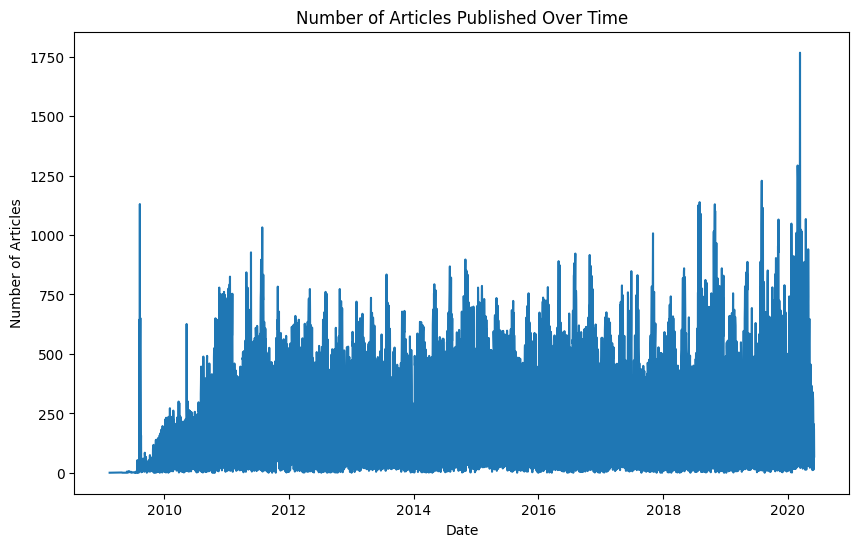


Number of Articles by Day of the Week:
day_of_week
Monday       254842
Tuesday      285468
Wednesday    289049
Thursday     289907
Friday       208511
Saturday       7486
Sunday        16078
Name: count, dtype: int64


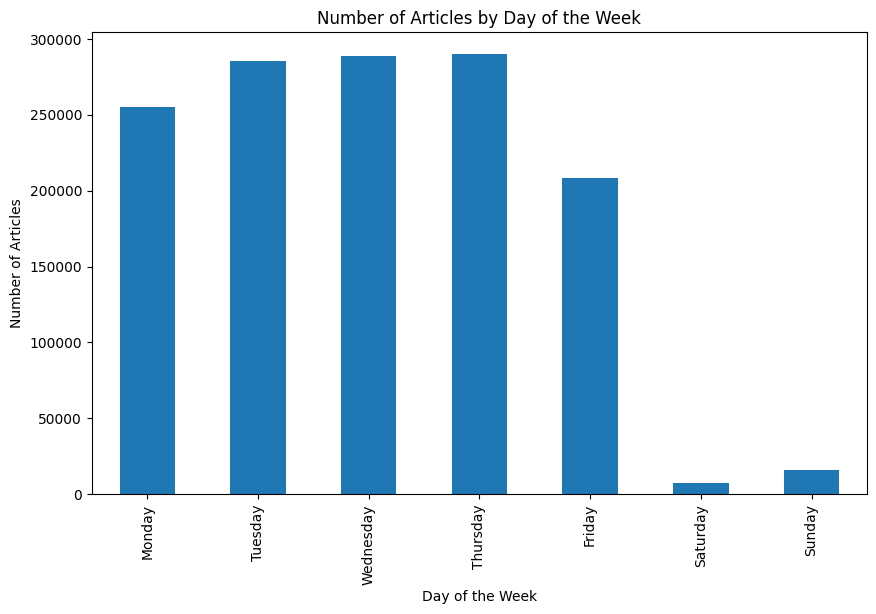

In [3]:
# Convert the date column to datetime format
# Using format='%Y-%m-%d %H:%M:%S' to match the data format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce', utc=True)

# Task 1: Descriptive Statistics for textual lengths (like headline length)
df['headline_length'] = df['headline'].apply(len)
headline_stats = df['headline_length'].describe()
print("Descriptive Statistics for Headline Lengths:")
print(headline_stats)

# Visualize the distribution of headline lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.show()

# Task 2: Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print("\nNumber of Articles per Publisher:")
print(publisher_counts)

# Visualize the number of articles per publisher
plt.figure(figsize=(10, 6))
publisher_counts.plot(kind='bar')
plt.title('Number of Articles per Publisher')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

# Task 3: Analyze publication dates to see trends over time
# Extracting the date part (ignoring the time)
df['publication_date'] = df['date'].dt.date
df['day_of_week'] = df['date'].dt.day_name()

# Group by date to get the number of articles per day
articles_per_day = df.groupby('publication_date').size()

print("\nNumber of Articles Published Over Time:")
print(articles_per_day)

# Visualize the number of articles over time
plt.figure(figsize=(10, 6))
articles_per_day.plot(kind='line')
plt.title('Number of Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

# Analyze the number of articles by day of the week
articles_by_day = df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print("\nNumber of Articles by Day of the Week:")
print(articles_by_day)

# Visualize the number of articles by day of the week
plt.figure(figsize=(10, 6))
articles_by_day.plot(kind='bar')
plt.title('Number of Articles by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.show()


### Text Analysis(Sentiment analysis & Topic Modeling):

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...


True

In [4]:
print(df.isnull().sum())

Unnamed: 0              0
headline                0
url                     0
publisher               0
date                55987
stock                   0
headline_length         0
publication_date    55987
day_of_week         55987
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype              
---  ------            --------------    -----              
 0   Unnamed: 0        1407328 non-null  int64              
 1   headline          1407328 non-null  object             
 2   url               1407328 non-null  object             
 3   publisher         1407328 non-null  object             
 4   date              1351341 non-null  datetime64[ns, UTC]
 5   stock             1407328 non-null  object             
 6   headline_length   1407328 non-null  int64              
 7   publication_date  1351341 non-null  object             
 8   day_of_week       1351341 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(6)
memory usage: 96.6+ MB


In [10]:
df.shape

(1407328, 9)

In [6]:
time_data = df['date'].apply(lambda x: pd.notna(x) and isinstance(x, pd.Timestamp) and x.time() != pd.Timestamp.min.time())
print(time_data.sum())


1351341


In [7]:
sentiment_data=df.copy()

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [9]:
# Calculate the sentiment of the headlines
sentiment_data['sentiment'] = sentiment_data['headline'].apply(lambda x: sia.polarity_scores(text=x)['compound'])

In [ ]:
sentiment_data = sentiment_data['date'].dt.date
sentiment_data = sentiment_data['date'].dt.time

In [23]:
sentiment_data

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,publication_date,day_of_week,sentiment,sentiment_category
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,NaT,A,39,NaT,NaN,0.0000,Neutral
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,NaT,A,42,NaT,NaN,0.0000,Neutral
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,NaT,A,29,NaT,NaN,0.0000,Neutral
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,NaT,A,44,NaT,NaN,0.0000,Neutral
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,NaT,A,87,NaT,NaN,0.2960,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29,ZX,38,2011-08-29,Monday,0.2023,Neutral
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22,ZX,52,2011-06-22,Wednesday,-0.3818,Negative
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21,ZX,56,2011-06-21,Tuesday,0.0000,Neutral
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21,ZX,54,2011-06-21,Tuesday,0.0000,Neutral


In [22]:
# Categorize the sentiment scores
sentiment_data['sentiment_category'] = pd.cut(sentiment_data['sentiment'], bins=[-1, -0.5, -0.0001, 0.5, 1], labels=['Very Negative', 'Negative', 'Neutral', 'Positive'])

In [24]:
sentiment_data

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,publication_date,day_of_week,sentiment,sentiment_category
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,NaT,A,39,NaT,NaN,0.0000,Neutral
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,NaT,A,42,NaT,NaN,0.0000,Neutral
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,NaT,A,29,NaT,NaN,0.0000,Neutral
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,NaT,A,44,NaT,NaN,0.0000,Neutral
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,NaT,A,87,NaT,NaN,0.2960,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29,ZX,38,2011-08-29,Monday,0.2023,Neutral
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22,ZX,52,2011-06-22,Wednesday,-0.3818,Negative
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21,ZX,56,2011-06-21,Tuesday,0.0000,Neutral
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21,ZX,54,2011-06-21,Tuesday,0.0000,Neutral


In [25]:
sentiment_data['sentiment_category'].value_counts()

sentiment_category
Neutral          1070915
Negative          182864
Positive          109718
Very Negative      43831
Name: count, dtype: int64

In [26]:
apple_data = sentiment_data[sentiment_data['stock'] == 'AAPL']
apple_data

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,publication_date,day_of_week,sentiment,sentiment_category
6680,7120,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,NaT,AAPL,69,NaT,NaN,0.5574,Positive
6681,7121,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,NaT,AAPL,45,NaT,NaN,0.0000,Neutral
6682,7122,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,NaT,AAPL,87,NaT,NaN,0.2023,Neutral
6683,7123,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,NaT,AAPL,65,NaT,NaN,0.0000,Neutral
6684,7124,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,NaT,AAPL,87,NaT,NaN,0.3818,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
7116,7585,"UBS Maintains Buy on Apple, Lowers Price Targe...",https://www.benzinga.com/news/20/03/15514989/u...,Vick Meyer,2020-03-10,AAPL,55,2020-03-10,Tuesday,-0.1280,Negative
7117,7586,123 Biggest Movers From Yesterday,https://www.benzinga.com/news/20/03/15514298/1...,Lisa Levin,2020-03-10,AAPL,33,2020-03-10,Tuesday,0.0000,Neutral
7118,7587,Crude Awakening: Energy Sector Takes A 20% Spi...,https://www.benzinga.com/news/earnings/20/03/1...,JJ Kinahan,2020-03-09,AAPL,91,2020-03-09,Monday,-0.9062,Very Negative
7119,7588,Investor Movement Index Summary: February 2020,https://www.benzinga.com/news/earnings/20/03/1...,TD Ameritrade,2020-03-09,AAPL,46,2020-03-09,Monday,0.0000,Neutral


### Sentiment of AAPL

In [31]:
apple_data_COUNT = apple_data['sentiment_category'].value_counts()
apple_data_COUNT 

sentiment_category
Neutral          298
Negative          74
Positive          43
Very Negative     26
Name: count, dtype: int64

C:\Users\Hp\AppData\Local\Temp\ipykernel_11780\1884119829.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=apple_data_COUNT .index, y=apple_data_COUNT .values, palette='viridis')


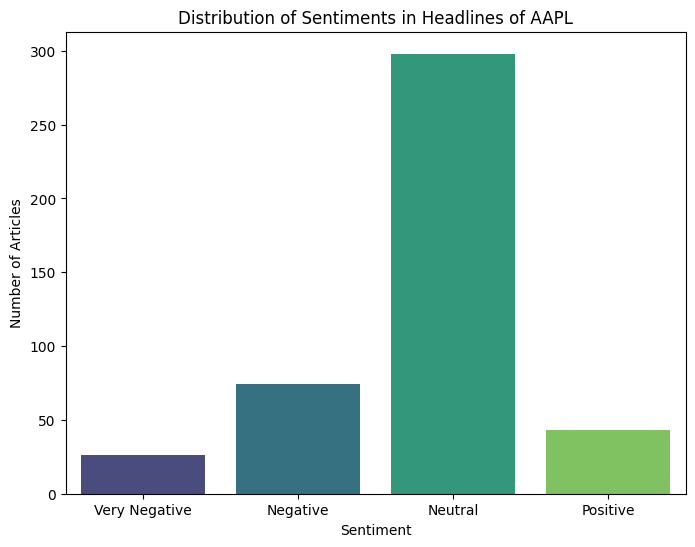

In [33]:
# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=apple_data_COUNT .index, y=apple_data_COUNT .values, palette='viridis')
plt.title('Distribution of Sentiments in Headlines of AAPL')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.show()

In [34]:
print(sentiment_data['date'].min(), sentiment_data['date'].max())

2009-02-14 00:00:00 2020-06-03 00:00:00


In [41]:
# Ensure 'date' column in AMZN_data is in datetime format
apple_data['date'] = pd.to_datetime(apple_data['date'], errors='coerce')
# Find the minimum and maximum dates
print(apple_data['date'].min(), apple_data['date'].max())

2020-03-09 00:00:00 2020-06-02 00:00:00


C:\Users\Hp\AppData\Local\Temp\ipykernel_11780\1059439515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_data['date'] = pd.to_datetime(apple_data['date'], errors='coerce')


### Sentiment of AMZN

In [35]:
AMZN_data = sentiment_data[sentiment_data['stock'] == 'AMZN']
AMZN_data
AMZN_data_COUNT = AMZN_data['sentiment_category'].value_counts()
AMZN_data_COUNT 

sentiment_category
Neutral          201
Negative          38
Positive          28
Very Negative     11
Name: count, dtype: int64

C:\Users\Hp\AppData\Local\Temp\ipykernel_11780\3853977233.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=AMZN_data_COUNT .index, y=AMZN_data_COUNT .values, palette='viridis')


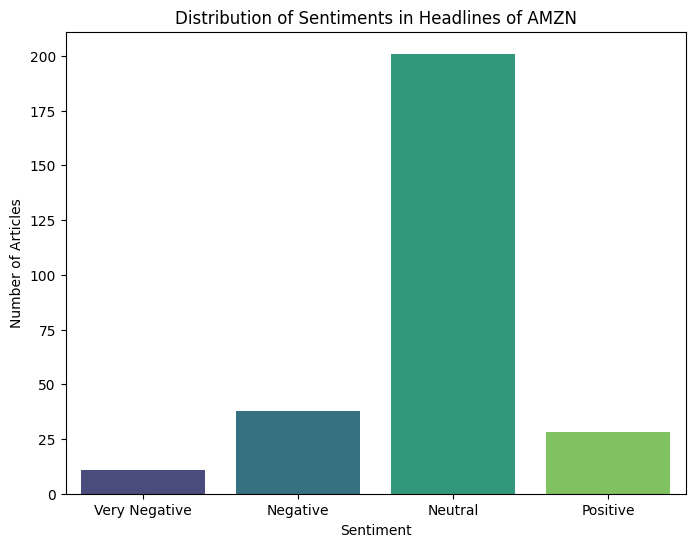

In [46]:
# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=AMZN_data_COUNT .index, y=AMZN_data_COUNT .values, palette='viridis')
plt.title('Distribution of Sentiments in Headlines of AMZN')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.show()

In [39]:
# Ensure 'date' column in AMZN_data is in datetime format
AMZN_data['date'] = pd.to_datetime(AMZN_data['date'], errors='coerce')

# Find the minimum and maximum dates
print(AMZN_data['date'].min(), AMZN_data['date'].max())


2020-04-27 00:00:00 2020-06-02 00:00:00


C:\Users\Hp\AppData\Local\Temp\ipykernel_11780\3395915760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMZN_data['date'] = pd.to_datetime(AMZN_data['date'], errors='coerce')


### Sentiment of Google

In [43]:
GOOG_data = sentiment_data[sentiment_data['stock'] == 'GOOG']
GOOG_data
GOOG_data_COUNT = GOOG_data['sentiment_category'].value_counts()
GOOG_data_COUNT 

sentiment_category
Neutral          840
Negative         169
Positive         140
Very Negative     50
Name: count, dtype: int64

C:\Users\Hp\AppData\Local\Temp\ipykernel_11780\628827540.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=GOOG_data_COUNT .index, y=GOOG_data_COUNT .values, palette='viridis')


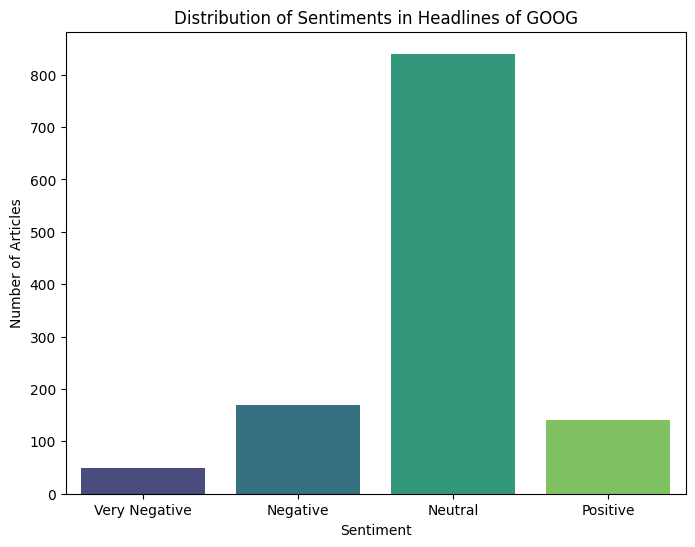

In [47]:
# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=GOOG_data_COUNT .index, y=GOOG_data_COUNT .values, palette='viridis')
plt.title('Distribution of Sentiments in Headlines of GOOG')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.show()

In [48]:
# Ensure 'date' column in AMZN_data is in datetime format
GOOG_data['date'] = pd.to_datetime(GOOG_data['date'], errors='coerce')

# Find the minimum and maximum dates
print(GOOG_data['date'].min(), GOOG_data['date'].max())


2018-11-13 00:00:00 2020-06-02 00:00:00


C:\Users\Hp\AppData\Local\Temp\ipykernel_11780\3310810263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GOOG_data['date'] = pd.to_datetime(GOOG_data['date'], errors='coerce')


### Sentiment of META

In [50]:
META_data = sentiment_data[sentiment_data['stock'] == 'META']
META_data
META_data_COUNT = META_data['sentiment_category'].value_counts()
META_data_COUNT 

sentiment_category
Very Negative    0
Negative         0
Neutral          0
Positive         0
Name: count, dtype: int64

### Sentiment of MSFT

In [51]:
MSFT_data = sentiment_data[sentiment_data['stock'] == 'MSFT']
MSFT_data
MSFT_data_COUNT = MSFT_data['sentiment_category'].value_counts()
MSFT_data_COUNT 

sentiment_category
Very Negative    0
Negative         0
Neutral          0
Positive         0
Name: count, dtype: int64

### Sentiment of NVDA

In [52]:
NVDA_data = sentiment_data[sentiment_data['stock'] == 'NVDA']
NVDA_data
NVDA_data_COUNT = NVDA_data['sentiment_category'].value_counts()
NVDA_data_COUNT 

sentiment_category
Neutral          2393
Negative          369
Positive          281
Very Negative     103
Name: count, dtype: int64

C:\Users\Hp\AppData\Local\Temp\ipykernel_11780\493447481.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=NVDA_data_COUNT .index, y=NVDA_data_COUNT .values, palette='viridis')


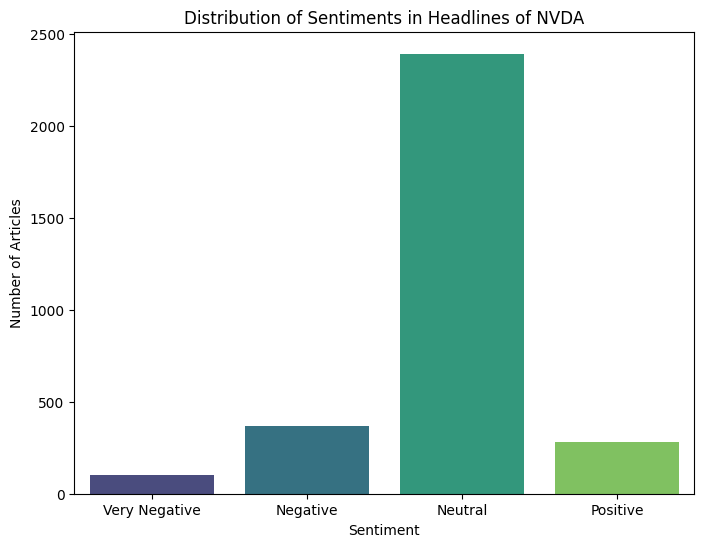

In [53]:
# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=NVDA_data_COUNT .index, y=NVDA_data_COUNT .values, palette='viridis')
plt.title('Distribution of Sentiments in Headlines of NVDA')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.show()

In [54]:
# Ensure 'date' column in AMZN_data is in datetime format
NVDA_data['date'] = pd.to_datetime(NVDA_data['date'], errors='coerce')

# Find the minimum and maximum dates
print(NVDA_data['date'].min(), NVDA_data['date'].max())


2011-03-03 00:00:00 2020-05-28 00:00:00


C:\Users\Hp\AppData\Local\Temp\ipykernel_11780\3591082467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NVDA_data['date'] = pd.to_datetime(NVDA_data['date'], errors='coerce')


### Sentiment of TSLA

In [55]:
TSLA_data = sentiment_data[sentiment_data['stock'] == 'TSLA']
TSLA_data
TSLA_data_COUNT = TSLA_data['sentiment_category'].value_counts()
TSLA_data_COUNT 

sentiment_category
Neutral          1418
Negative          221
Positive          172
Very Negative      64
Name: count, dtype: int64

C:\Users\Hp\AppData\Local\Temp\ipykernel_11780\4015252206.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=TSLA_data_COUNT .index, y=TSLA_data_COUNT .values, palette='viridis')


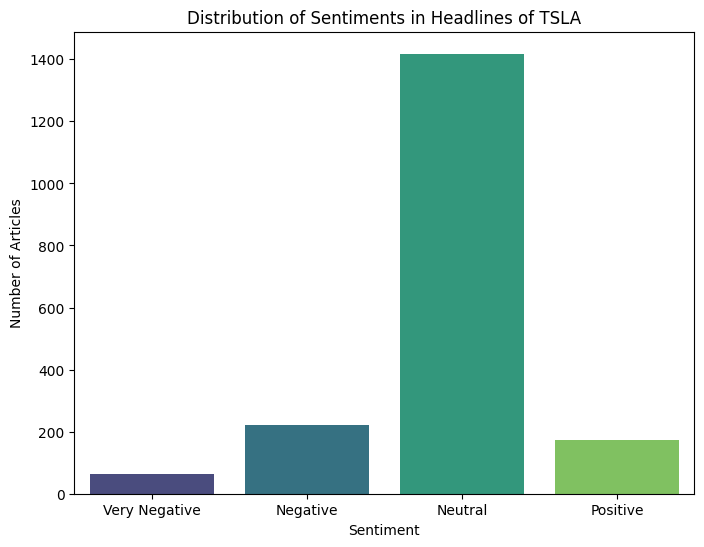

In [56]:
# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=TSLA_data_COUNT .index, y=TSLA_data_COUNT .values, palette='viridis')
plt.title('Distribution of Sentiments in Headlines of TSLA')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.show()

In [57]:
# Ensure 'date' column in AMZN_data is in datetime format
TSLA_data['date'] = pd.to_datetime(TSLA_data['date'], errors='coerce')

# Find the minimum and maximum dates
print(TSLA_data['date'].min(), TSLA_data['date'].max())


2019-07-01 00:00:00 2020-06-02 00:00:00


C:\Users\Hp\AppData\Local\Temp\ipykernel_11780\4214918235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TSLA_data['date'] = pd.to_datetime(TSLA_data['date'], errors='coerce')


### TOPIC Modeling

In [65]:
# Download stopwords from NLTK
nltk.download('stopwords')

# Preprocessing for topic modeling
def preprocess_text(text):
    text = text.lower()
    text = nltk.RegexpTokenizer(r"\w+").tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopwords]
    return ' '.join(text)

# Apply preprocessing
df['processed_headline'] = df['headline'].apply(preprocess_text)

# Vectorize text data
vectorizer = CountVectorizer(max_features=1000)  # Limit to top 1000 words
X = vectorizer.fit_transform(df['processed_headline'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=0)  # Adjust number of topics as needed
lda.fit(X)

# Get topic terms
feature_names = vectorizer.get_feature_names_out()
topics = lda.components_

# Display top words per topic
num_words = 10
for topic_idx, topic in enumerate(topics):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))
    print()

Topic #1:
stocks pt buy target maintains price raises session 00 moving

Topic #2:
top benzinga says announces stocks upgrades downgrades industry etf energy

Topic #3:
earnings stock scheduled 10 watch stocks analyst alert option may

Topic #4:
shares market update trading higher mid companies lower new stocks

Topic #5:
vs est eps reports sales sees estimate q4 q1 q2



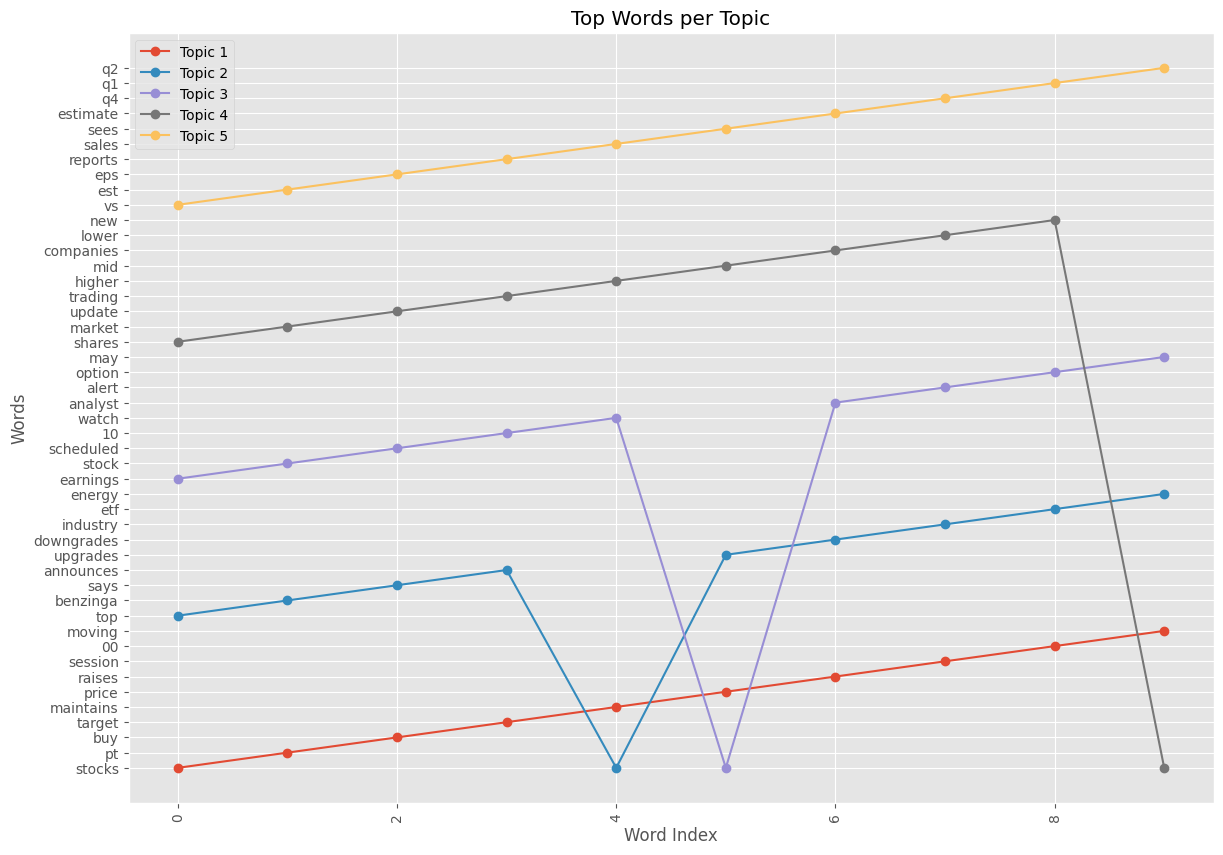

In [62]:
topic_words = []
for topic_idx, topic in enumerate(topics):
    words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
    topic_words.append(words)

topic_df = pd.DataFrame(topic_words, columns=[f"Word {i+1}" for i in range(num_words)])
topic_df.index.name = 'Topic'

# Plot the top words for each topic
fig, ax = plt.subplots(figsize=(14, 10))
for i, words in enumerate(topic_words):
    ax.plot(words, label=f"Topic {i+1}", marker='o')

ax.set_title('Top Words per Topic')
ax.set_xlabel('Word Index')
ax.set_ylabel('Words')
ax.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

### Time Series Analysis

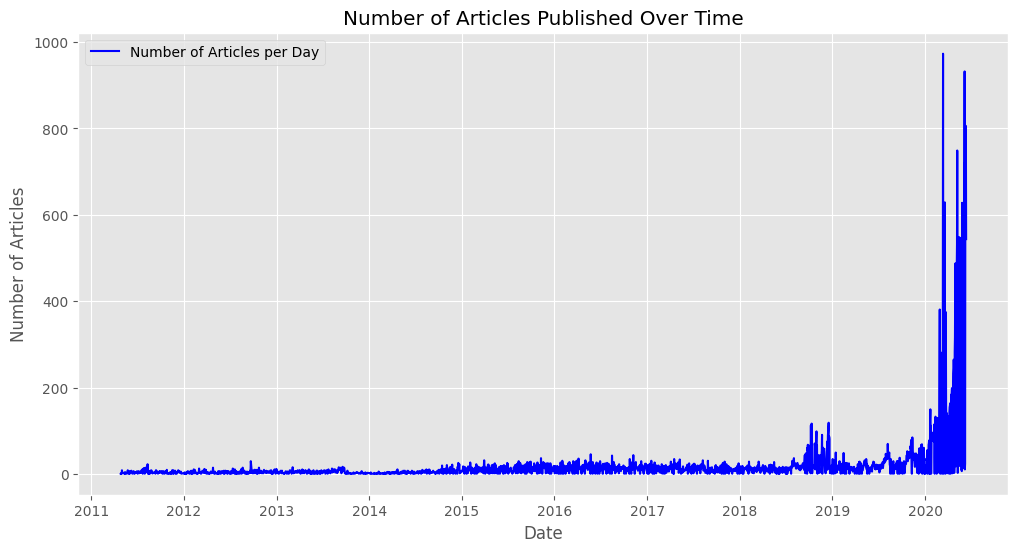

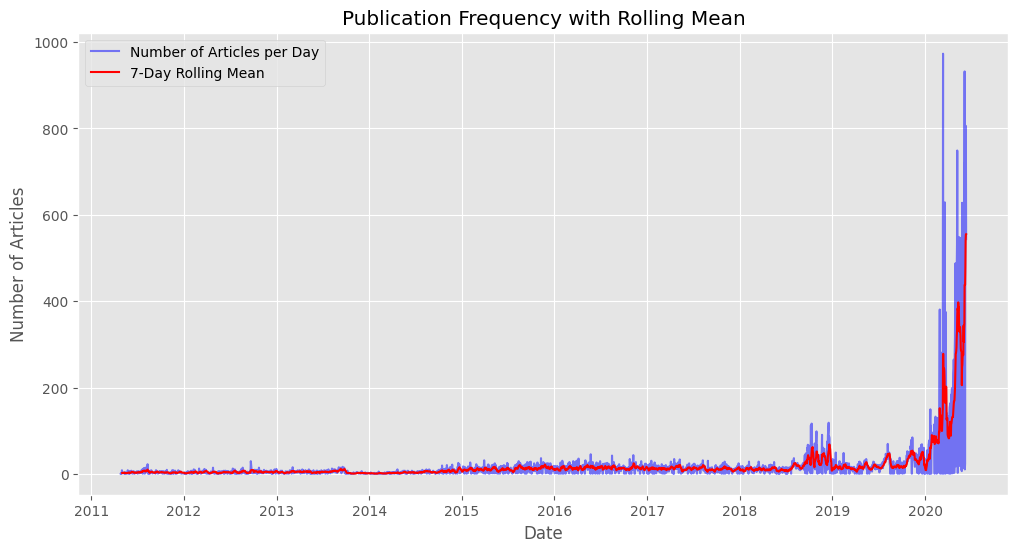

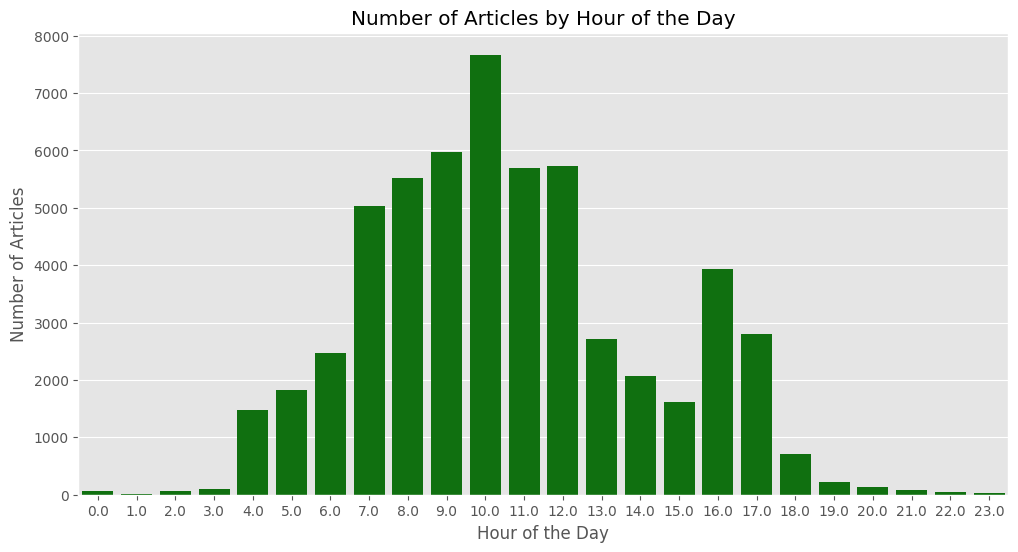

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(r'C:\Users\Hp\Desktop\10_Academy\week-1\Data\raw_analyst_ratings.csv\raw_analyst_ratings.csv')

# Convert the date column to datetime format with timezone information
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce')

# Task 1: Analyze publication frequency over time
# Group by date to get the number of articles per day
df['publication_date'] = df['date'].dt.date
articles_per_day = df.groupby('publication_date').size()

# Visualize the number of articles published over time
plt.figure(figsize=(12, 6))
plt.plot(articles_per_day, label='Number of Articles per Day', color='blue')
plt.title('Number of Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.show()

# Task 2: Identify spikes in publication frequency
# Rolling mean to smooth the series and detect spikes
rolling_mean = articles_per_day.rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(articles_per_day, label='Number of Articles per Day', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='7-Day Rolling Mean', color='red')
plt.title('Publication Frequency with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.show()

# Task 3: Analyze the time of day when most news is released
df['time_of_day'] = df['date'].dt.hour

# Count the number of articles published at each hour of the day
articles_by_hour = df['time_of_day'].value_counts().sort_index()

# Visualize the number of articles by hour of the day
plt.figure(figsize=(12, 6))
sns.barplot(x=articles_by_hour.index, y=articles_by_hour.values, color='green')
plt.title('Number of Articles by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Articles')
plt.show()

### Publisher Analysis


Top Domains:
domain
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


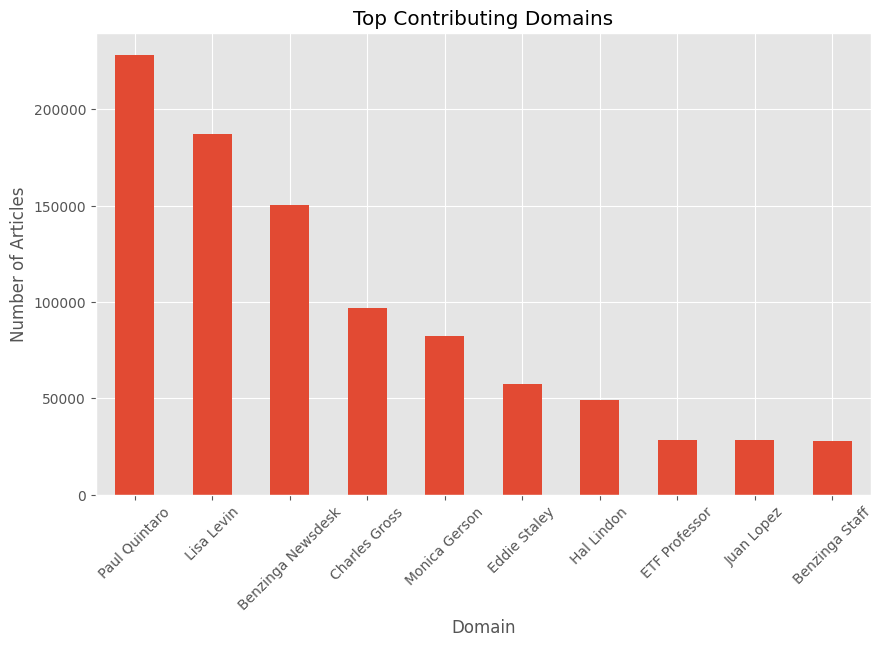


Number of articles mentioning 'earnings' or 'profit': 96748

Number of Articles Mentioning 'Earnings' or 'Profit' by Publisher:
publisher
ABNNewswire           1
Aaron Jackson.Ed      1
Abe Raymond          13
Abhi Rao              5
Adam Parker           1
                   ... 
pconfidential         6
strichie              8
superman              6
tradermark           68
webmaster           554
Length: 336, dtype: int64


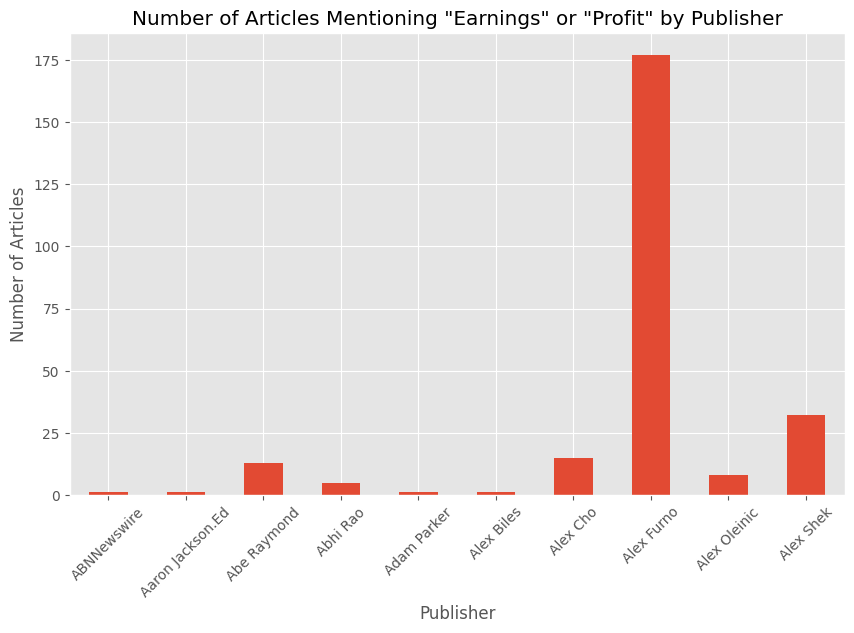

In [71]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r'C:\Users\Hp\Desktop\10_Academy\week-1\Data\raw_analyst_ratings.csv\raw_analyst_ratings.csv')

# Step 1: Extract Domains from Email Addresses using Regex
def extract_domain(email):

    match = re.search(r'@([\w.-]+)', email)
    return match.group(1) if match else email

df['domain'] = df['publisher'].apply(extract_domain)

# Count the frequency of each domain
domain_counts = df['domain'].value_counts()
print("\nTop Domains:")
print(domain_counts.head(10))  # Adjust the number to your need

# Visualize the top domains

plt.figure(figsize=(10, 6))
domain_counts.head(10).plot(kind='bar')
plt.title('Top Contributing Domains')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

# Step 2: Use Regex to Identify Patterns in Headlines
# Example: Find headlines mentioning "earnings" or "profit"
df['mention_earnings'] = df['headline'].apply(lambda x: bool(re.search(r'\b(earnings|profit)\b', x, re.IGNORECASE)))

# Count the number of articles mentioning earnings or profit
earnings_count = df['mention_earnings'].sum()
print(f"\nNumber of articles mentioning 'earnings' or 'profit': {earnings_count}")

# Step 3: Analyze the difference in news types by publishers based on regex
# Example: Compare the number of articles mentioning earnings by each publisher
publisher_earnings = df[df['mention_earnings']].groupby('publisher').size()
print("\nNumber of Articles Mentioning 'Earnings' or 'Profit' by Publisher:")
print(publisher_earnings)

# Visualize the comparison
plt.figure(figsize=(10, 6))
publisher_earnings.head(10).plot(kind='bar')
plt.title('Number of Articles Mentioning "Earnings" or "Profit" by Publisher')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()